#### **Event Study - R. v Hydro Quebec**



Clean return file written to zellerbach_returns.csv
       AAR  Std. E. AAR      CAAR  Std. E. CAAR  T-stat  P-value
-10  0.016      0.00588  0.016 **       0.00588    2.78     0.01
-9  -0.013      0.00588     0.003       0.00831    0.37     0.71
-8  -0.002      0.00588     0.001       0.01018    0.13     0.90
-7   0.007      0.00588     0.008       0.01176    0.68     0.49
-6   0.001      0.00588     0.009       0.01315    0.69     0.49
-5  -0.015      0.00588    -0.006       0.01440   -0.43     0.67
-4   0.007      0.00588     0.001       0.01556    0.05     0.96
-3   0.006      0.00588     0.007       0.01663    0.42     0.67
-2  -0.005      0.00588     0.002       0.01764    0.13     0.90
-1   0.011      0.00588     0.014       0.01859    0.73     0.46
0    0.007      0.00588     0.021       0.01950    1.06     0.29
1    0.005      0.00588     0.025       0.02037    1.25     0.21
2   -0.000      0.00588     0.025       0.02120    1.19     0.23
3   -0.008      0.00588     0.017     

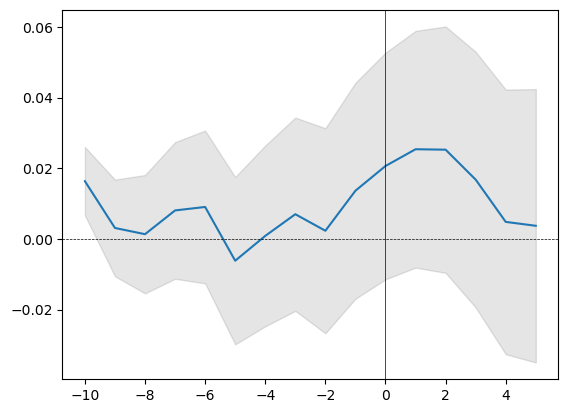

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eventstudy as es

RAW_CSV   = "zellerbach_data.csv"      # original upload
RET_CSV   = "zellerbach_returns.csv"             # clean file we will create

df = pd.read_csv(RAW_CSV, parse_dates=["date"])

# convert the TSX price level to a simple return
df["tsx_ret"] = df["tsx"].pct_change()           # (P_t − P_{t-1}) / P_{t-1}

# drop the first line (NaN return) and the old price column
df = df.dropna(subset=["tsx_ret"]).drop(columns=["tsx"])

# save the returns‑only file
df.to_csv(RET_CSV, index=False)
print(f"Clean return file written to {RET_CSV}")

RETURNS_CSV = "zellerbach_returns.csv"
FACTORS_CSV = "tsx_factor_data.csv"


# Load security‑level
es.Single.import_returns(
    RETURNS_CSV,
    is_price=False,
    date_format="%Y-%m-%d"
)

# load Fama–French factors
es.Single.import_FamaFrench(
    FACTORS_CSV,
    rescale_factor=True,
    date_format="%Y-%m-%d"
)

# Build the list of events
event_date = np.datetime64("1988-03-24")
market_tkr = "tsx_ret"                        

cols = pd.read_csv(RETURNS_CSV, nrows=1).columns
security_cols = [c for c in cols if c not in {"date", market_tkr}]

event_list = [
    {"security_ticker": sec,
     "market_ticker":  market_tkr,
     "event_date":     event_date}
    for sec in security_cols
]

# Aggregate MARKET‑MODEL event study
hydro_agg = es.Multiple.from_list(
    event_list,
    es.Single.market_model,
    event_window=(-10, 5),
    estimation_size=240,
    buffer_size=0,
    ignore_errors=True
)

# Results & plot
print(hydro_agg.results(decimals=[3,5,3,5,2,2]))
hydro_agg.plot(confidence=0.95)
plt.show()


In [70]:
import pandas as pd

# 1) --- load the two input files ------------------------------------------------
factors = pd.read_csv("tsx_factor_data.csv")          # ← columns: date, Mkt‑RF, SMB, HML …
mapping = pd.read_csv("csv_datechange.csv")           # ← two columns named old_date,new_date

# Grab the two dates (assumes the mapping file has only one row)
old_date = pd.to_datetime(mapping.loc[0, "old_date"])
new_date = pd.to_datetime(mapping.loc[0, "new_date"])

# 2) --- normalise the factor‑file date column to datetime ----------------------
factors["date"] = pd.to_datetime(factors["date"])

# 3) --- move the ‘old_date’ row to ‘new_date’ ----------------------------------
factors.loc[factors["date"] == old_date, "date"] = new_date

# 4) --- drop every row that is now strictly before the new date ----------------
factors = factors[factors["date"] >= new_date]

# 5) --- if the file already contained a row *at* new_date, remove the original -
# (after step 3 you’d have two identical dates otherwise)
factors = factors.drop_duplicates(subset=["date"], keep="last")

# 6) --- save -------------------------------------------------------------------
factors.sort_values("date").to_csv("2tsx_factor.csv", index=False)
print("✅ 2tsx_factor.csv written!")


✅ 2tsx_factor.csv written!


       AAR  Std. E. AAR       CAAR  Std. E. CAAR  T-stat  P-value
-10  0.005       0.0034      0.005       0.00340    1.43     0.15
-9   0.002       0.0034      0.007       0.00481    1.40     0.16
-8  -0.005       0.0034      0.002       0.00589    0.29     0.77
-7  -0.002       0.0034       -0.0       0.00680   -0.04     0.97
-6  -0.007       0.0034     -0.008       0.00761   -1.02     0.31
-5   0.005       0.0034     -0.003       0.00833   -0.35     0.73
-4   0.001       0.0034     -0.002       0.00900   -0.19     0.85
-3  -0.005       0.0034     -0.007       0.00962   -0.68     0.50
-2  -0.009       0.0034     -0.015       0.01021   -1.47     0.14
-1  -0.007       0.0034  -0.022 **       0.01076   -2.09     0.04
0    0.003       0.0034   -0.019 *       0.01128   -1.71     0.09
1    0.006       0.0034     -0.013       0.01179   -1.14     0.25
2   -0.004       0.0034     -0.017       0.01227   -1.41     0.16
3    0.002       0.0034     -0.016       0.01273   -1.23     0.22
4   -0.002

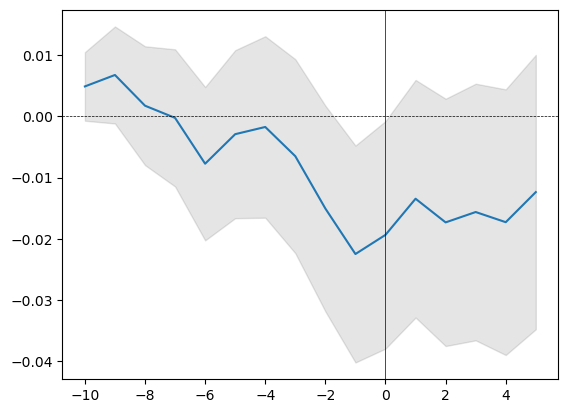

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eventstudy as es

# security‑level daily returns
RETURNS_CSV = "hydroqc_data.csv" 
es.Single.import_returns(
    RETURNS_CSV,
    is_price=False,
    date_format="%Y-%m-%d"
)

# Fama–French daily factors
FACTORS_CSV = "tsx_factor_data.csv"
es.Single.import_FamaFrench(
    FACTORS_CSV,
    rescale_factor=True,
    date_format="%Y-%m-%d"
)

event_date = np.datetime64("1997-09-18")
tickers = [c for c in pd.read_csv(RETURNS_CSV, nrows=1).columns if c != "date"]

event_list = [{"security_ticker": t, "event_date": event_date} for t in tickers]

# Aggregate event study
hydro_agg = es.Multiple.from_list(
    event_list=event_list,
    event_study_model=es.Single.FamaFrench_5factor,
    event_window=(-10, 5),
    estimation_size=200,
    buffer_size=0,
    ignore_errors=True
)

# Output
# tabular results
print(hydro_agg.results(decimals=[3,5,3,5,2,2]))

# optional visualisation
hydro_agg.plot(confidence=0.95)
plt.show()


       AAR  Std. E. AAR       CAAR  Std. E. CAAR  T-stat  P-value
-10  0.028      0.00398  0.028 ***       0.00398    7.12     0.00
-9  -0.003      0.00398  0.025 ***       0.00563    4.41     0.00
-8  -0.001      0.00398  0.023 ***       0.00690    3.40     0.00
-7  -0.018      0.00398      0.006       0.00797    0.70     0.48
-6   0.018      0.00398   0.024 **       0.00891    2.70     0.01
-5  -0.039      0.00398     -0.015       0.00976   -1.51     0.13
-4   0.026      0.00398      0.011       0.01054    1.03     0.30
-3  -0.001      0.00398       0.01       0.01127    0.89     0.37
-2  -0.029      0.00398     -0.019       0.01195   -1.61     0.11
-1   0.021      0.00398      0.002       0.01260    0.15     0.88
0   -0.006      0.00398     -0.004       0.01321   -0.27     0.79
1    0.027      0.00398    0.023 *       0.01380    1.69     0.09
2    0.003      0.00398    0.027 *       0.01437    1.86     0.06
3    0.000      0.00398    0.027 *       0.01491    1.81     0.07
4    0.004

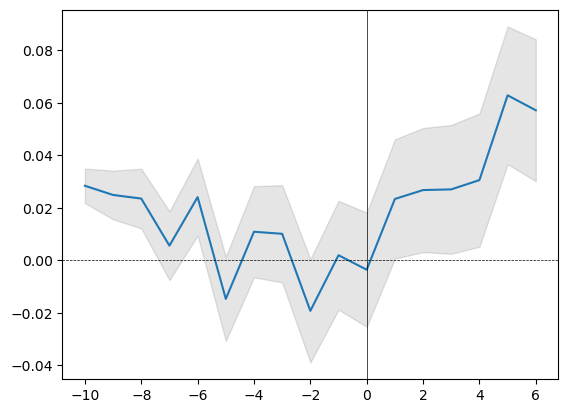

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eventstudy as es

# security‑level daily returns
RETURNS_CSV = "2ghg_data.csv" 
es.Single.import_returns(
    RETURNS_CSV,
    is_price=False,
    date_format="%Y-%m-%d"
)

# Fama–French daily factors
FACTORS_CSV = "2tsx_factor.csv"
es.Single.import_FamaFrench(
    FACTORS_CSV,
    rescale_factor=False,
    date_format="%Y-%m-%d"
)

event_date = np.datetime64("2021-03-25")
tickers = [c for c in pd.read_csv(RETURNS_CSV, nrows=1).columns if c != "date"]

event_list = [{"security_ticker": t, "event_date": event_date} for t in tickers]

# Aggregate event study
hydro_agg = es.Multiple.from_list(
    event_list=event_list,
    event_study_model=es.Single.FamaFrench_5factor,
    event_window=(-10, 6),
    estimation_size=400,
    buffer_size=0,
    ignore_errors=False
)

# Output
# tabular results
print(hydro_agg.results(decimals=[3,5,3,5,2,2]))

# optional visualisation
hydro_agg.plot(confidence=0.95)
plt.show()



      AAR  Std. E. AAR        CAAR  Std. E. CAAR  T-stat  P-value
-8 -0.005      0.00232   -0.005 **       0.00232   -2.14     0.03
-7  0.002      0.00232      -0.003       0.00328   -0.83     0.40
-6 -0.011      0.00232  -0.013 ***       0.00401   -3.32     0.00
-5 -0.001      0.00232  -0.015 ***       0.00463   -3.18     0.00
-4  0.010      0.00232      -0.004       0.00518   -0.82     0.41
-3  0.005      0.00232       0.001       0.00567    0.17     0.87
-2 -0.008      0.00232      -0.008       0.00613   -1.22     0.22
-1  0.001      0.00232      -0.007       0.00655   -1.01     0.31
0   0.024      0.00232    0.017 **       0.00695    2.46     0.01
1  -0.010      0.00232       0.007       0.00733    1.02     0.31
2   0.003      0.00232       0.011       0.00768    1.40     0.16
3   0.013      0.00232   0.023 ***       0.00803    2.91     0.00
4   0.011      0.00232   0.034 ***       0.00835    4.12     0.00
5   0.009      0.00232   0.043 ***       0.00867    4.99     0.00
6  -0.007 

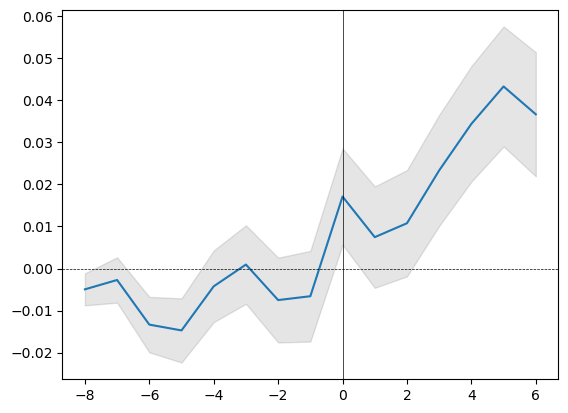

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eventstudy as es

# security‑level daily returns
RETURNS_CSV = "iaa_data.csv" 
es.Single.import_returns(
    RETURNS_CSV,
    is_price=False,
    date_format="%Y-%m-%d"
)

# Fama–French daily factors
FACTORS_CSV = "tsx_factor_data.csv"
es.Single.import_FamaFrench(
    FACTORS_CSV,
    rescale_factor=False,
    date_format="%Y-%m-%d"
)

event_date = np.datetime64("2023-10-13")
tickers = [c for c in pd.read_csv(RETURNS_CSV, nrows=1).columns if c != "date"]

event_list = [{"security_ticker": t, "event_date": event_date} for t in tickers]

# Aggregate event study
hydro_agg = es.Multiple.from_list(
    event_list=event_list,
    event_study_model=es.Single.FamaFrench_3factor,
    event_window=(-8, 6),
    estimation_size=230,
    buffer_size=0,
    ignore_errors=True
)

# Output
# tabular results
print(hydro_agg.results(decimals=[3,5,3,5,2,2]))

# optional visualisation
hydro_agg.plot(confidence=0.95)
plt.show()
